In [ ]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
np.random.seed(42)
X, y = make_blobs(centers=[[2,2], [-2,-2]])
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
def local_density_estimation(x, X_y, window_size, num_features, smoothing_rate):
  return [ (np.sum( np.abs(x[i] - X_y[:, i]) <= window_size ) + smoothing_rate)
            / (X_y.shape[0] + smoothing_rate * num_features)
            for i in range(num_features)]

def normal_density_estimation(x, y, u, sig, num_classes, num_features):
  # u - матрица (n_classes, n_features) математических ожиданий каждого признака в каждом классе
  # sig - матрица (n_classes, n_features) среднеквадоатичных отклонений каждого признака в каждом классе
  y = int(y)
  return 1 / (sig[y] * (2 * np.pi) ** 0.5) * np.exp( -((x-u[y]) ** 2) / (2 * sig[y] ** 2) )

In [ ]:
class NaiveBayes:
  def __init__(self, smoothing_rate=1., window_size=.5, density_estimation='local', penalties=None):
    # smoothing_rate - параметр сглаживания, для объектов, не встречающихся в обучающей выборке
    self.__smoothing_rate = smoothing_rate

    # density_estimation - метод для оценки условной плотности
    self.__density_estimation_name = density_estimation

    # penalties - матрица penalties.shape = (n_classes, n_classes),
    # penalties[i, j] - коэффициент штрафа за присвоение класса j объекту класса i
    if penalties:
      self.penalties_ = np.array(penalties)

    # ширина окна, для локальной оценки плотности
    self.__window_size = window_size

    self.__fitted = False

  def predict(self, X):
    if not self.__fitted:
      print('Этот экземпляр еще не обучен, используйте метод fit')
      return

    # логарифм условной плотности p(x|y), где x из X для каждого класса
    logit = np.array(
        [
            [
                np.sum(  np.log( self.__conditional_density_estimation(x, y=c) )  )
                # находим плотности для каждого класса
                for c in self.__classes
            ]
            # находим условную плотность для каждого предсказываемого объекта
            for x in X
        ]
    )

    # возвращаем метку наиболее правдоподобного класса класса
    return np.argmax(np.log(self.__lambda_y) + np.log(self.__P_y) + logit + np.log(self.penalties_[0,1]), axis=1)


  def fit(self, X, y):
    # X - набор объектов, матрца: X.shape = (n_samples, n_features)
    # y - набор классов, задаваемых целочисленными метками

    self.__X = X
    self.__y = y.astype('int')

    # множество возможных различных классов
    self.__classes = set(self.__y)

    if not hasattr(self, 'penalties_'):
      self.penalties_ = np.ones((len(self.__classes), len(self.__classes))) - np.identity(len(self.__classes))

    # число признаков
    self.__num_features = X.shape[1]

    # безусловная вероятность появления объекта класса y
    self.__P_y = [np.sum(self.__y == c) / self.__y.shape[0] for c in self.__classes]
    self.__lambda_y = [np.sum(self.penalties_[c]) for c in self.__classes]
    self.__fitted = True

    if self.__density_estimation_name == 'normal':
      self.__u = np.array([ [np.mean(self.__X[:, i][self.__y == c]) for i in range(self.__num_features)] for c in self.__classes ])
      self.__sig = np.array([ [np.std(self.__X[:, i][self.__y == c]) for i in range(self.__num_features)] for c in self.__classes ])

  # оценка условной плотности признаков объекта x,
  # как частота встречаемости значения x[i] среди
  # значений i-го признака объектов обучающей выборки
  # для класса y
  def __conditional_density_estimation(self, x, y):
    X_y = self.__X[self.__y == y]

    if self.__density_estimation_name == 'local':
      densities_estim = local_density_estimation(x, X_y, self.__window_size, self.__num_features, self.__smoothing_rate)
    elif self.__density_estimation_name == 'normal':
      densities_estim = normal_density_estimation(x, y, self.__u, self.__sig, len(self.__classes), self.__num_features)

    return densities_estim

In [ ]:
clf = NaiveBayes(density_estimation='local')
clf.fit(X_train, y_train)

In [ ]:
accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))

1.0

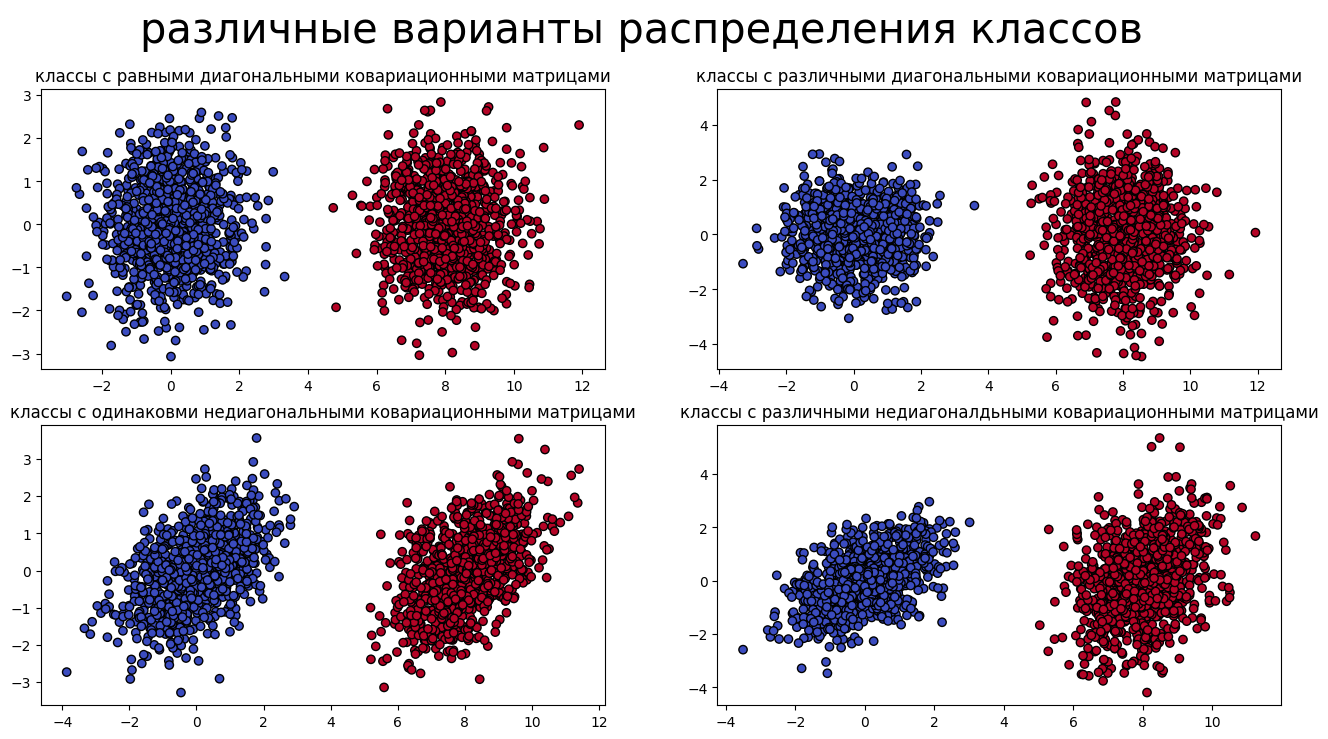

In [ ]:
# классы с равными диагональными ковариационными матрицами
X_blob0 = np.random.multivariate_normal([0,0], [[1,0], [0,1]], size=1000)
X_blob1 = np.random.multivariate_normal([8,0], [[1,0], [0,1]], size=1000)

X_blob_0 = np.concatenate((X_blob0, X_blob1))
y_blob_0 = np.concatenate(  ( np.zeros(X_blob0.shape[0]), np.ones(X_blob1.shape[0]) )  )


# классы с различными диагональными ковариационными матрицами
X_blob0 = np.random.multivariate_normal([0,0], [[1,0], [0,1]], size=1000)
X_blob1 = np.random.multivariate_normal([8,0], [[1,0], [0,2]], size=1000)

X_blob_1 = np.concatenate((X_blob0, X_blob1))
y_blob_1 = np.concatenate(  ( np.zeros(X_blob0.shape[0]), np.ones(X_blob1.shape[0]) )  )


# классы с одинаковми недиагональными ковариационными матрицами
X_blob0 = np.random.multivariate_normal([0,0], [[1, 0.5], [0.5, 1]], size=1000)
X_blob1 = np.random.multivariate_normal([8,0], [[1, 0.5], [0.5, 1]], size=1000)

X_blob_2 = np.concatenate((X_blob0, X_blob1))
y_blob_2 = np.concatenate(  ( np.zeros(X_blob0.shape[0]), np.ones(X_blob1.shape[0]) )  )


# классы с различными недиагоналдьными ковариационными матрицами
X_blob0 = np.random.multivariate_normal([0,0], [[1, 0.5], [0.5, 1]], size=1000)
X_blob1 = np.random.multivariate_normal([8,0], [[1, 0.5], [0.5, 2]], size=1000)

X_blob_3 = np.concatenate((X_blob0, X_blob1))
y_blob_3 = np.concatenate(  ( np.zeros(X_blob0.shape[0]), np.ones(X_blob1.shape[0]) )  )


fig, ax = plt.subplots(2, 2, figsize=(16, 8))

ax[0,0].scatter(X_blob_0[:, 0], X_blob_0[:, 1], c=y_blob_0, cmap=cm.coolwarm, edgecolors='k')
ax[0,0].set_title('классы с равными диагональными ковариационными матрицами')

ax[0,1].scatter(X_blob_1[:, 0], X_blob_1[:, 1], c=y_blob_1, cmap=cm.coolwarm, edgecolors='k')
ax[0,1].set_title('классы с различными диагональными ковариационными матрицами')

ax[1,0].scatter(X_blob_2[:, 0], X_blob_2[:, 1], c=y_blob_2, cmap=cm.coolwarm, edgecolors='k')
ax[1,0].set_title('классы с одинаковми недиагональными ковариационными матрицами')

ax[1,1].scatter(X_blob_3[:, 0], X_blob_3[:, 1], c=y_blob_3, cmap=cm.coolwarm, edgecolors='k')
ax[1,1].set_title('классы с различными недиагоналдьными ковариационными матрицами')


plt.suptitle('различные варианты распределения классов', fontsize=30)
plt.show()

In [ ]:
clf_0 = NaiveBayes(density_estimation='normal')
clf_0.fit(X_blob_0, y_blob_0)

clf_1 = NaiveBayes(density_estimation='normal')
clf_1.fit(X_blob_1, y_blob_1)

clf_2 = NaiveBayes(density_estimation='normal')
clf_2.fit(X_blob_2, y_blob_2)

clf_3 = NaiveBayes(density_estimation='normal')
clf_3.fit(X_blob_3, y_blob_3)

In [ ]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 2, x.max() + 2
    y_min, y_max = y.min() - 2, y.max() + 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    out = ax.contourf(xx, yy, Z, **params)
    return out

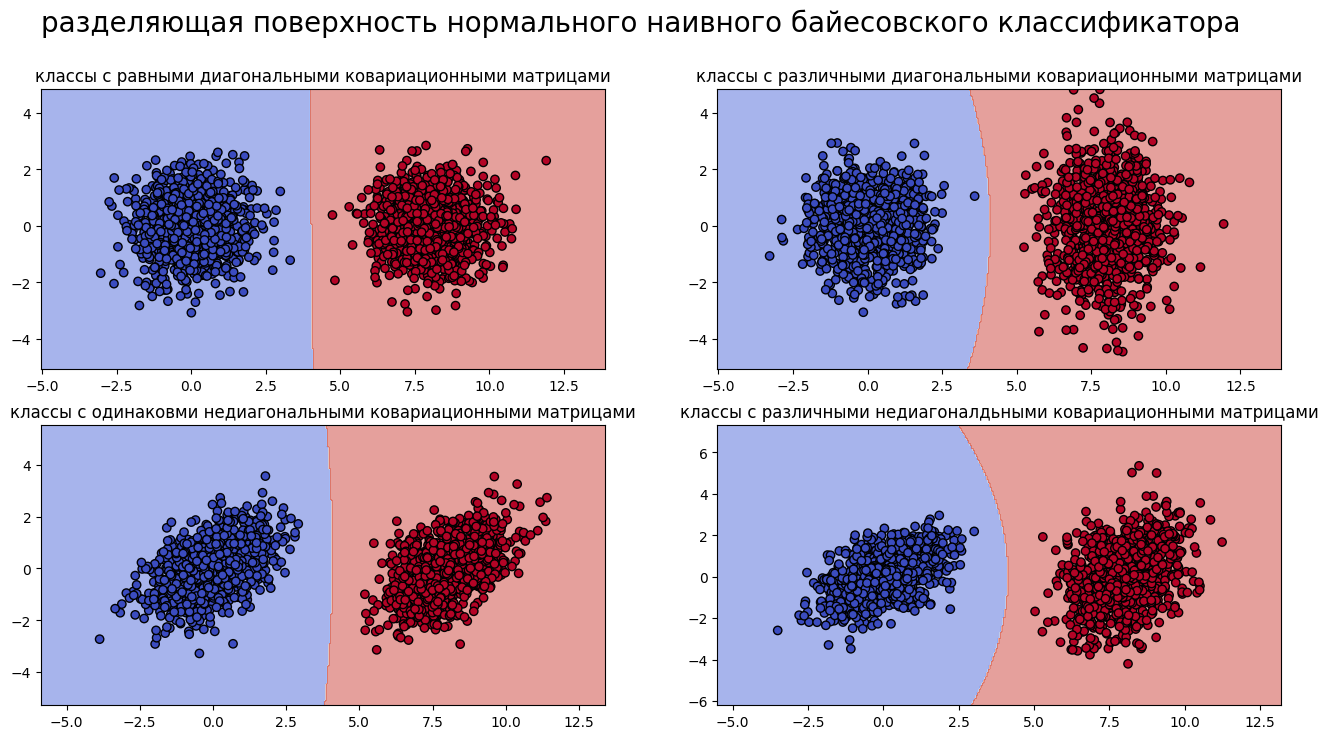

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plt.suptitle('разделяющая поверхность нормального наивного байесовского классификатора', fontsize=20)

xx_0, yy_0 = make_meshgrid(X_blob_0[:, 0], X_blob_0[:, 1], h=0.05)
plot_contours(ax[0,0], clf_0, xx_0, yy_0, cmap=cm.coolwarm, alpha=0.5)
ax[0,0].scatter(X_blob_0[:, 0], X_blob_0[:, 1], c=y_blob_0, cmap=cm.coolwarm, edgecolors='k')
ax[0,0].set_title('классы с равными диагональными ковариационными матрицами')

xx_1, yy_1 = make_meshgrid(X_blob_1[:, 0], X_blob_1[:, 1], h=0.05)
plot_contours(ax[0,1], clf_1, xx_0, yy_0, cmap=cm.coolwarm, alpha=0.5)
ax[0,1].scatter(X_blob_1[:, 0], X_blob_1[:, 1], c=y_blob_1, cmap=cm.coolwarm, edgecolors='k')
ax[0,1].set_title('классы с различными диагональными ковариационными матрицами')

xx_2, yy_2 = make_meshgrid(X_blob_2[:, 0], X_blob_2[:, 1], h=0.05)
plot_contours(ax[1,0], clf_2, xx_2, yy_2, cmap=cm.coolwarm, alpha=0.5)
ax[1,0].scatter(X_blob_2[:, 0], X_blob_2[:, 1], c=y_blob_2, cmap=cm.coolwarm, edgecolors='k')
ax[1,0].set_title('классы с одинаковми недиагональными ковариационными матрицами')

xx_3, yy_3 = make_meshgrid(X_blob_3[:, 0], X_blob_3[:, 1], h=0.05)
plot_contours(ax[1,1], clf_3, xx_3, yy_3, cmap=cm.coolwarm, alpha=0.5)
ax[1,1].scatter(X_blob_3[:, 0], X_blob_3[:, 1], c=y_blob_3, cmap=cm.coolwarm, edgecolors='k')
ax[1,1].set_title('классы с различными недиагоналдьными ковариационными матрицами')

plt.show()

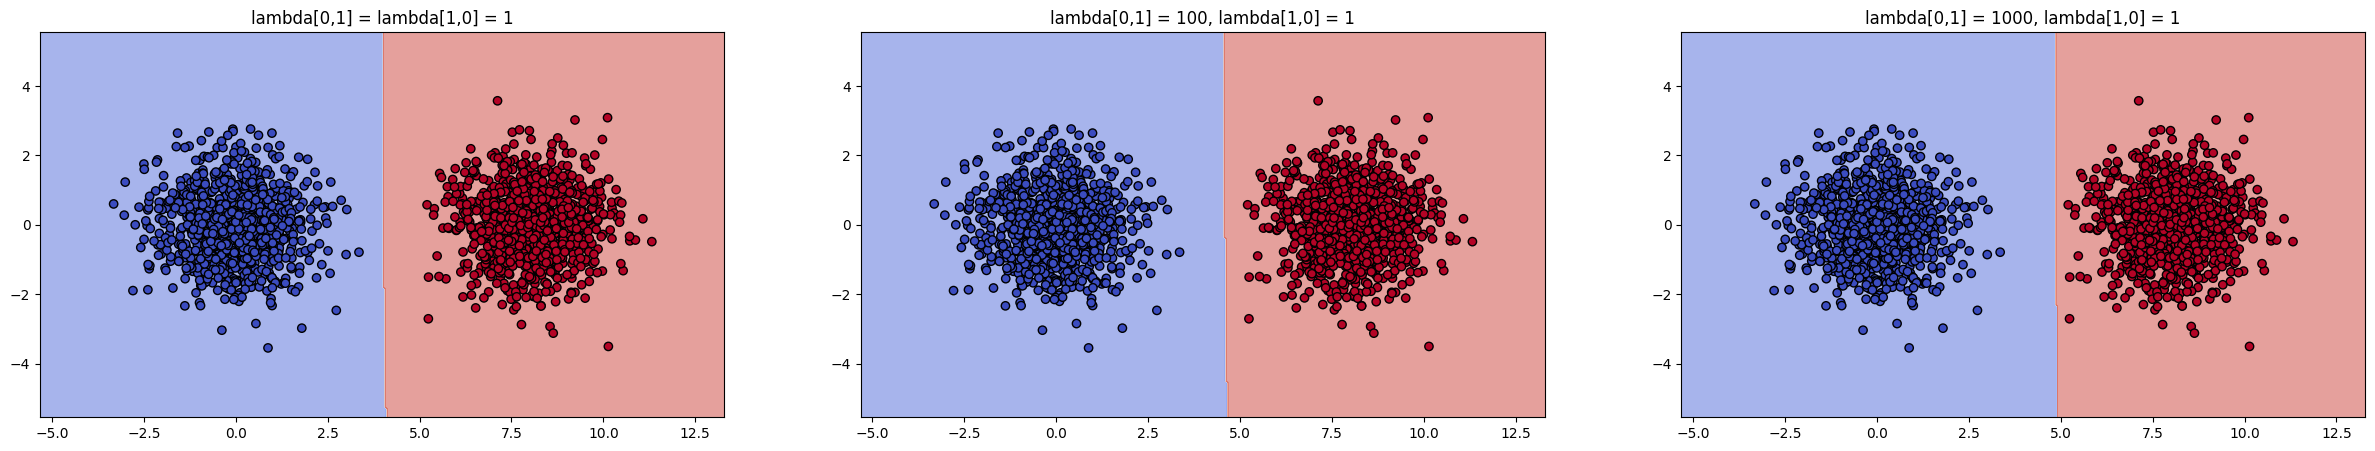

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 5))

X_blob0 = np.random.multivariate_normal([0,0], [[1,0], [0,1]], size=1000)
X_blob1 = np.random.multivariate_normal([8,0], [[1,0], [0,1]], size=1000)

X_blob = np.concatenate((X_blob0, X_blob1))
y_blob = np.concatenate(  ( np.zeros(X_blob0.shape[0]), np.ones(X_blob1.shape[0]) )  )

clf = NaiveBayes(density_estimation='normal', penalties=[[0,1], [1,0]])
clf.fit(X_blob_0, y_blob_0)

xx, yy = make_meshgrid(X_blob[:, 0], X_blob[:, 1], h=0.05)
plot_contours(ax[0], clf, xx, yy, cmap=cm.coolwarm, alpha=0.5)
ax[0].scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=cm.coolwarm, edgecolors='k')
ax[0].set_title('lambda[0,1] = lambda[1,0] = 1')

clf = NaiveBayes(density_estimation='normal', penalties=[[0,100], [1,0]])
clf.fit(X_blob_0, y_blob_0)

xx, yy = make_meshgrid(X_blob[:, 0], X_blob[:, 1], h=0.05)
plot_contours(ax[1], clf, xx, yy, cmap=cm.coolwarm, alpha=0.5)
ax[1].scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=cm.coolwarm, edgecolors='k')
ax[1].set_title('lambda[0,1] = 100, lambda[1,0] = 1')

clf = NaiveBayes(density_estimation='normal', penalties=[[0,1000], [1,0]])
clf.fit(X_blob_0, y_blob_0)

xx, yy = make_meshgrid(X_blob[:, 0], X_blob[:, 1], h=0.05)
plot_contours(ax[2], clf, xx, yy, cmap=cm.coolwarm, alpha=0.5)
ax[2].scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=cm.coolwarm, edgecolors='k')
ax[2].set_title('lambda[0,1] = 1000, lambda[1,0] = 1')

plt.show()

In [ ]:
# многомерная гауссовская функция распределения
def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)

    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

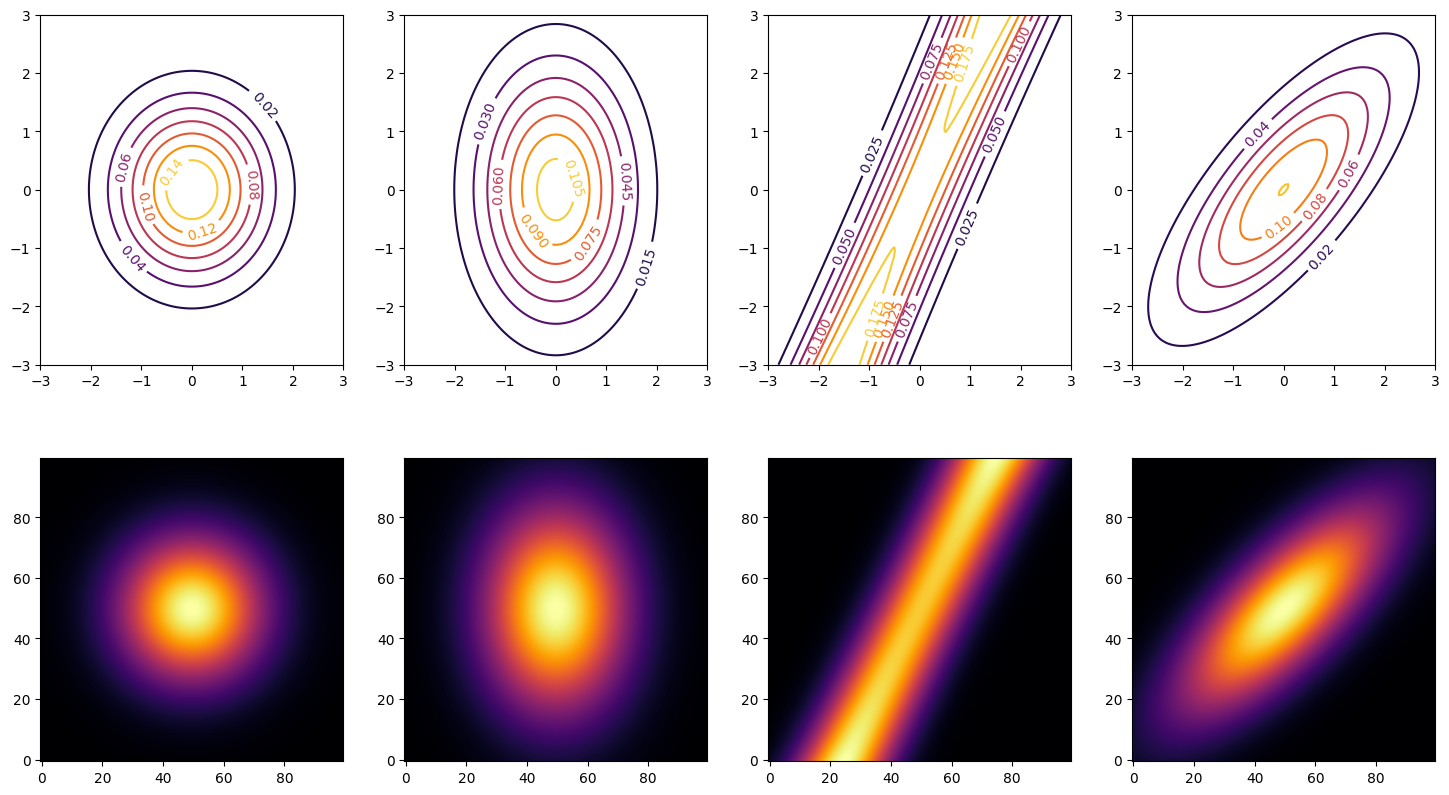

In [ ]:
N = 100
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

mu_0 = np.array([0., 0.])
Sigma_0 = np.array([[ 1. , 0.0], [0.0,  1.]])
Z_0 = multivariate_gaussian(pos, mu_0, Sigma_0)

mu_1 = np.array([0., 0.])
Sigma_1 = np.array([[ 1. , 0.0], [0.0,  2.]])
Z_1 = multivariate_gaussian(pos, mu_1, Sigma_1)

mu_2 = np.array([0., 0.])
Sigma_2 = np.array([[ 0.5, 2.], [0.1,  2.1]])
Z_2 = multivariate_gaussian(pos, mu_2, Sigma_2)

mu_3 = np.array([0., 0.])
Sigma_3 = np.array([[ 2., 1.5], [1.5,  2.]])
Z_3 = multivariate_gaussian(pos, mu_3, Sigma_3)

fig, ax = plt.subplots(2, 4, figsize=(18,10))

c_0 = ax[0, 0].contour(X, Y, Z_0, cmap='inferno')
c_1 = ax[0, 1].contour(X, Y, Z_1, cmap='inferno')
c_2 = ax[0, 2].contour(X, Y, Z_2, cmap='inferno')
c_3 = ax[0, 3].contour(X, Y, Z_3, cmap='inferno')

ax[0, 0].clabel(c_0)
ax[0, 1].clabel(c_1)
ax[0, 2].clabel(c_2)
ax[0, 3].clabel(c_3)

ax[1, 0].imshow(Z_0, interpolation='spline16', cmap='inferno', origin='lower')
ax[1, 1].imshow(Z_1, interpolation='spline16', cmap='inferno', origin='lower')
ax[1, 2].imshow(Z_2, interpolation='spline16', cmap='inferno', origin='lower')
ax[1, 3].imshow(Z_3, interpolation='spline16', cmap='inferno', origin='lower')

plt.show()

In [ ]:
# нормальный дискримантиивный анализ
class NDA:
  def fit(self, X, y):
    self.__classes = set(y)
    self.__P_y = [np.sum(y == c) / y.shape[0] for c in self.__classes]
    self.__mu = np.array([np.mean(X[y==c], axis=0) for c in self.__classes])
    self.__cov = np.array([np.cov(X[y==c].T) for c in self.__classes])

  def predict(self, X):
    logit = np.array([np.log( multivariate_gaussian(X, self.__mu[i], self.__cov[i]) ) for i in range(len(self.__classes))]).T
    log_P_y = np.log(self.__P_y)[np.newaxis,...].repeat(logit.shape[0], axis=0)
    return np.argmax(log_P_y + logit, axis=1)

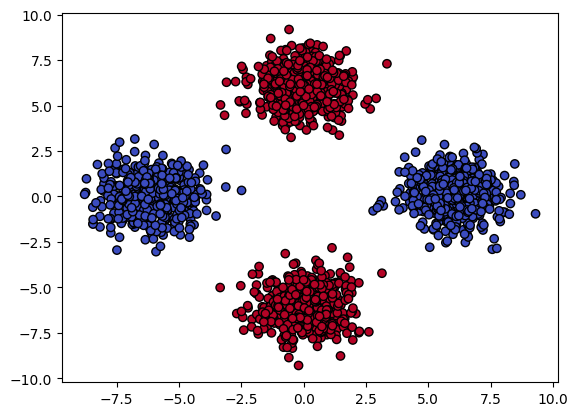

In [ ]:
X_blob_0_0 = np.random.multivariate_normal([6,0], [[1, 0], [0, 1]], size=500)
X_blob_0_1 = np.random.multivariate_normal([-6,0], [[1, 0], [0, 1]], size=500)

X_blob_1_0 = np.random.multivariate_normal([0,6], [[1, 0], [0, 1]], size=500)
X_blob_1_1 = np.random.multivariate_normal([0,-6], [[1, 0], [0, 1]], size=500)

X_blob_4 = np.concatenate((X_blob_0_0, X_blob_0_1, X_blob_1_0, X_blob_1_1))
y_blob_4 = np.concatenate(  ( np.zeros(X_blob_0_0.shape[0] + X_blob_0_1.shape[0]), np.ones(X_blob_1_0.shape[0] + X_blob_1_1.shape[0]) )  )

fig, ax = plt.subplots()
ax.scatter(X_blob_4[:, 0], X_blob_4[:, 1], c=y_blob_4, cmap=cm.coolwarm, edgecolors='k')
plt.show()

In [ ]:
clf_nda_0 = NDA()
clf_nda_0.fit(X_blob_0, y_blob_0)

clf_nda_1 = NDA()
clf_nda_1.fit(X_blob_1, y_blob_1)

clf_nda_2 = NDA()
clf_nda_2.fit(X_blob_2, y_blob_2)

clf_nda_3 = NDA()
clf_nda_3.fit(X_blob_3, y_blob_3)

clf_nda_4 = NDA()
clf_nda_4.fit(X_blob_4, y_blob_4)

<ipython-input-15-8eef87ee6bf6>:11: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  out = ax.contourf(xx, yy, Z, **params)


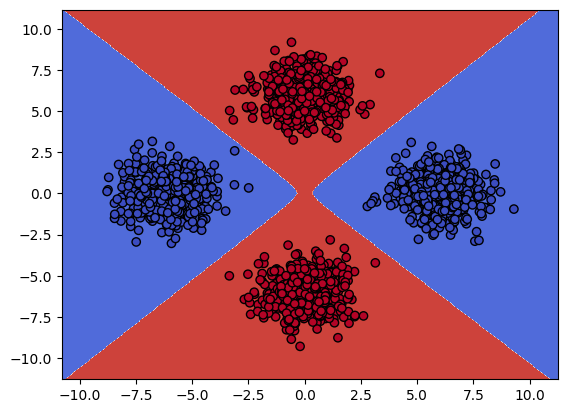

In [ ]:
fig, ax = plt.subplots()
xx, yy = make_meshgrid(X_blob_4[:, 0], X_blob_4[:, 1], h=0.05)
plot_contours(ax, clf_nda_4, xx, yy, cmap=cm.coolwarm, edgecolors='k')
ax.scatter(X_blob_4[:, 0], X_blob_4[:, 1], c=y_blob_4, cmap=cm.coolwarm, edgecolors='k')
plt.show()

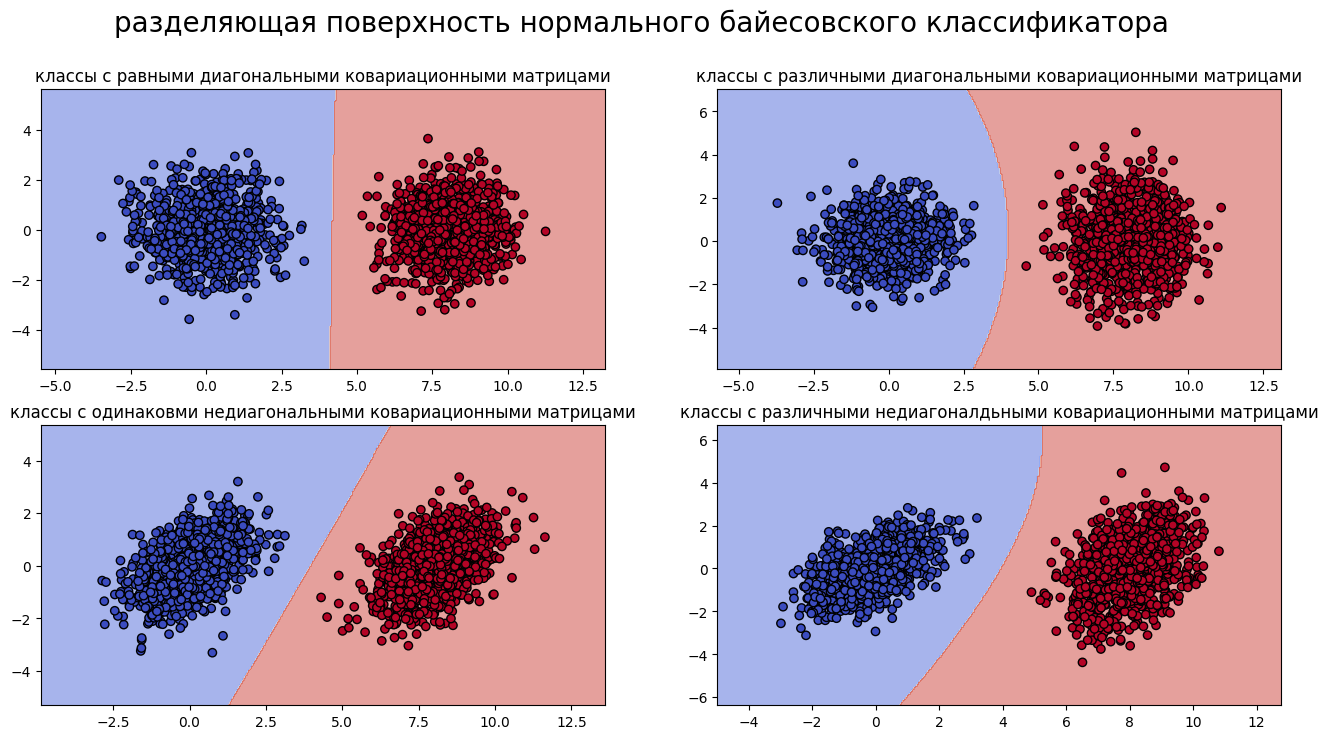

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plt.suptitle('разделяющая поверхность нормального байесовского классификатора', fontsize=20)

xx_0, yy_0 = make_meshgrid(X_blob_0[:, 0], X_blob_0[:, 1], h=0.05)
plot_contours(ax[0,0], clf_nda_0, xx_0, yy_0, cmap=cm.coolwarm, alpha=0.5)
ax[0,0].scatter(X_blob_0[:, 0], X_blob_0[:, 1], c=y_blob_0, cmap=cm.coolwarm, edgecolors='k')
ax[0,0].set_title('классы с равными диагональными ковариационными матрицами')

xx_1, yy_1 = make_meshgrid(X_blob_1[:, 0], X_blob_1[:, 1], h=0.05)
plot_contours(ax[0,1], clf_nda_1 , xx_1, yy_1, cmap=cm.coolwarm, alpha=0.5)
ax[0,1].scatter(X_blob_1[:, 0], X_blob_1[:, 1], c=y_blob_1, cmap=cm.coolwarm, edgecolors='k')
ax[0,1].set_title('классы с различными диагональными ковариационными матрицами')

xx_2, yy_2 = make_meshgrid(X_blob_2[:, 0], X_blob_2[:, 1], h=0.05)
plot_contours(ax[1,0], clf_nda_2, xx_2, yy_2, cmap=cm.coolwarm, alpha=0.5)
ax[1,0].scatter(X_blob_2[:, 0], X_blob_2[:, 1], c=y_blob_2, cmap=cm.coolwarm, edgecolors='k')
ax[1,0].set_title('классы с одинаковми недиагональными ковариационными матрицами')

xx_3, yy_3 = make_meshgrid(X_blob_3[:, 0], X_blob_3[:, 1], h=0.05)
plot_contours(ax[1,1], clf_nda_3, xx_3, yy_3, cmap=cm.coolwarm, alpha=0.5)
ax[1,1].scatter(X_blob_3[:, 0], X_blob_3[:, 1], c=y_blob_3, cmap=cm.coolwarm, edgecolors='k')
ax[1,1].set_title('классы с различными недиагоналдьными ковариационными матрицами')

plt.show()

In [ ]:
clf_nda = NDA()
clf_nda.fit(X_blob_0, y_blob_0)

In [ ]:
class LDF:
  def fit(self, X, y):
    self.__classes = set(y)
    self.__P_y = [np.sum(y == c) / y.shape[0] for c in self.__classes]
    self.__mu = np.array([np.mean(X[y==c], axis=0) for c in self.__classes])
    self.__cov = np.cov(X[y==0].T)
    self.__cov_inv = np.linalg.inv(self.__cov)


  def predict(self, X):
    alpha_y = [np.dot(self.__cov_inv, self.__mu[c]) for c in self.__classes]
    beta_y = [np.log(self.__P_y) - 0.5 * np.dot(self.__mu[c].T, self.__cov_inv) for c in self.__classes]
    p = [np.dot(X, alpha) + np.repeat(beta[...,np.newaxis], X.shape[0], axis=1) for alpha, beta in zip(alpha_y, beta_y)]
    return np.argmax(p, axis=0)

In [ ]:
clf = LDF()
clf.fit(X_train, y_train)

In [ ]:
y_pred=clf.predict(X_test)
y_pred.shape

<zip object at 0x7f5411ea2300> [array([2.27135644, 2.07332886]), array([-2.58269728, -1.85693827])] [array([-1.78960469, -1.7706336 ]), array([0.63742217, 0.19449996])]


(2, 25)

In [ ]:
accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))

ValueError: ignored